In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Load Dataset

In [ ]:
# Membaca file CSV
df = pd.read_csv('/content/CarPrice_Assignment.csv')

In [ ]:
# Menampilkan baris awal dataset
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


# Exploratory Data Analysis (EDA)

In [ ]:
# Informasi dasar dataset
print("Info Dataset:")
df.info()

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null

In [ ]:
# Statistik deskriptif
print("Statistik Deskriptif:")
print(df.describe())

Statistik Deskriptif:
           car_ID   symboling   wheelbase   carlength    carwidth   carheight  \
count  205.000000  205.000000  205.000000  205.000000  205.000000  205.000000   
mean   103.000000    0.834146   98.756585  174.049268   65.907805   53.724878   
std     59.322565    1.245307    6.021776   12.337289    2.145204    2.443522   
min      1.000000   -2.000000   86.600000  141.100000   60.300000   47.800000   
25%     52.000000    0.000000   94.500000  166.300000   64.100000   52.000000   
50%    103.000000    1.000000   97.000000  173.200000   65.500000   54.100000   
75%    154.000000    2.000000  102.400000  183.100000   66.900000   55.500000   
max    205.000000    3.000000  120.900000  208.100000   72.300000   59.800000   

        curbweight  enginesize   boreratio      stroke  compressionratio  \
count   205.000000  205.000000  205.000000  205.000000        205.000000   
mean   2555.565854  126.907317    3.329756    3.255415         10.142537   
std     520.680204  

In [ ]:
# Jumlah nilai kosong per kolom
print("Cek Missing Values:")
print(df.isnull().sum())

Cek Missing Values:
car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64


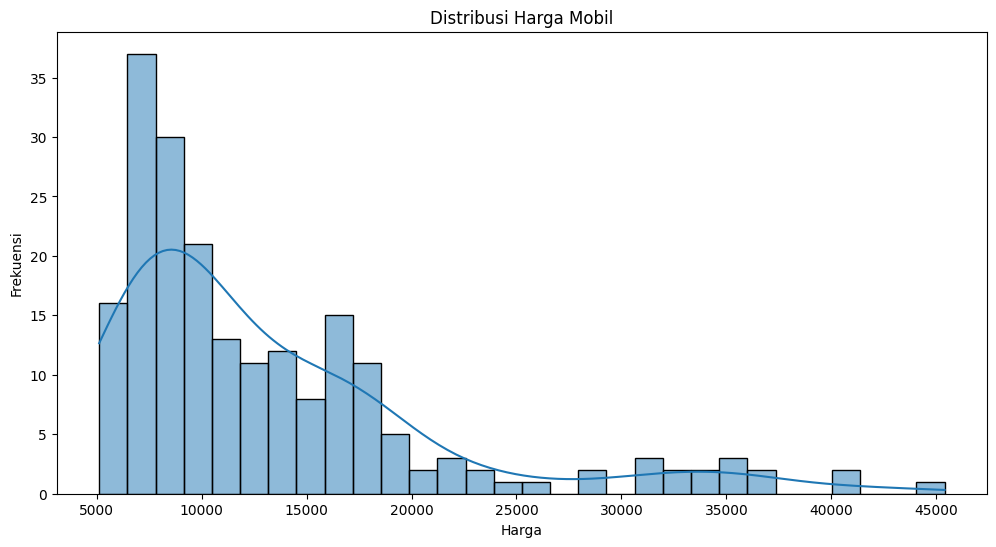

In [ ]:
# Visualisasi distribusi harga mobil
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title("Distribusi Harga Mobil")
plt.xlabel("Harga")
plt.ylabel("Frekuensi")
plt.show()

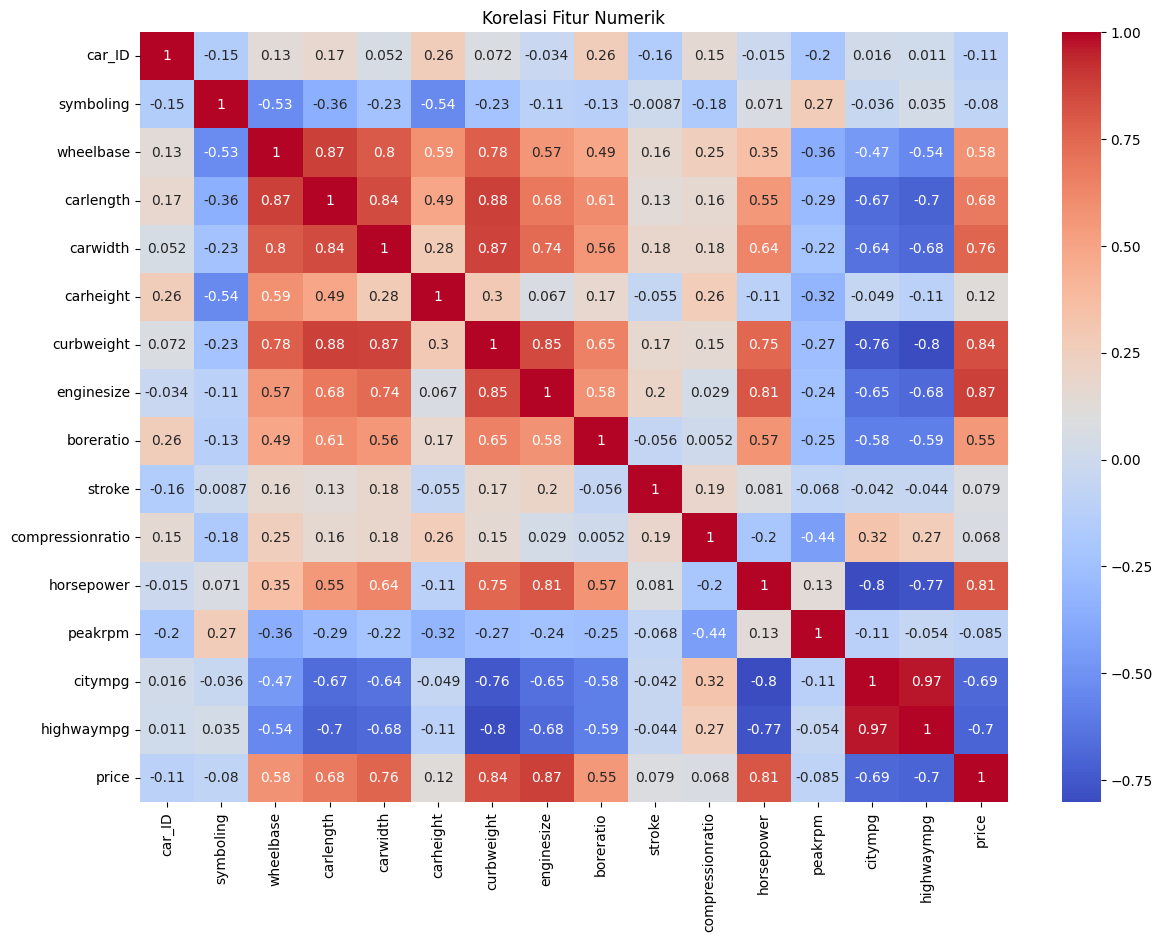

In [ ]:
# Korelasi fitur numerik
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Korelasi Fitur Numerik")
plt.show()

# Preprocessing

In [ ]:
# Drop kolom tidak berguna
df = df.drop(columns=['car_ID', 'symboling'])

In [ ]:
# Normalisasi CarName
df['CarName'] = df['CarName'].str.lower()
df['CarName'] = df['CarName'].replace({'maxda': 'mazda', 'porcshce': 'porsche',
                                      'toyouta': 'toyota', 'vw': 'volkswagen'})

In [ ]:
# Mengganti kolom 'CarName' ke 'brand'
df['brand'] = df['CarName'].apply(lambda x: x.split(' ')[0])
df = df.drop(columns=['CarName'])

In [ ]:
# Konvert price ke IDR
df['price'] = df['price'] * 16314

In [ ]:
cat_cols = df.select_dtypes(include='object').columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

In [ ]:
df.head()

,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,brand
0,1,0,1,0,2,0,88.6,168.8,64.1,48.8,...,5,3.47,2.68,9.0,111,5000,21,27,220157430.0,0
1,1,0,1,0,2,0,88.6,168.8,64.1,48.8,...,5,3.47,2.68,9.0,111,5000,21,27,269181000.0,0
2,1,0,1,2,2,0,94.5,171.2,65.5,52.4,...,5,2.68,3.47,9.0,154,5000,19,26,269181000.0,0
3,1,0,0,3,1,0,99.8,176.6,66.2,54.3,...,5,3.19,3.40,10.0,102,5500,24,30,227580300.0,1
4,1,0,0,3,0,0,99.4,176.6,66.4,54.3,...,5,3.19,3.40,8.0,115,5500,18,22,284679300.0,1


# Modeling

In [ ]:
# Split Data
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Modeling dengan XGBoost
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Evaluation

In [ ]:
# Evaluasi Model
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

MAE: 27229484.16
MSE: 1483424195822788.00
RMSE: 38515246.28
R2 Score: 0.9294


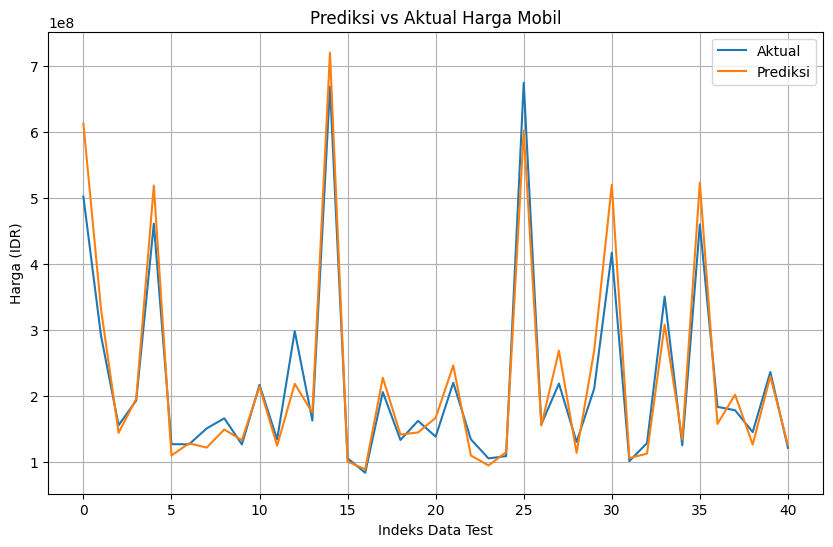

In [ ]:
# Visualisasi Prediksi vs Aktual
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Aktual')
plt.plot(y_pred, label='Prediksi')
plt.title('Prediksi vs Aktual Harga Mobil')
plt.xlabel('Indeks Data Test')
plt.ylabel('Harga (IDR)')
plt.legend()
plt.grid(True)
plt.show()

# Inference

In [ ]:
# Inference (Predict new data)
new_data = pd.DataFrame({
    'fueltype': [0],
    'aspiration': [0],
    'doornumber': [0],
    'carbody': [0],
    'drivewheel': [0],
    'enginelocation': [0],
    'wheelbase': [88.6],
    'carlength': [168.8],
    'carwidth': [64.1],
    'carheight': [48.8],
    'curbweight': [2548],
    'enginetype': [0],
    'cylindernumber': [0],
    'enginesize': [130],
    'fuelsystem': [0],
    'boreratio': [3.47],
    'stroke': [2.68],
    'compressionratio': [9.0],
    'horsepower': [111],
    'peakrpm': [5000],
    'citympg': [21],
    'highwaympg': [27],
    'brand': [0]
})

predicted_price = model.predict(new_data)

print(f"Prediksi harga mobil baru: Rp {predicted_price[0]:,.2f}")

Prediksi harga mobil baru: Rp 226,783,392.00
